In [1]:
from os import listdir
from os.path import isdir, join
import os
import librosa
import random
import numpy as np
import matplotlib.pyplot as plt
import python_speech_features

In [2]:
# Dataset path and view possible targets
dataset_path = 'C:\\Users\\Iulia\\Desktop\\speech_reco\\data'
for name in listdir(dataset_path):
    if isdir(join(dataset_path, name)):
        print(name)

lumina
noise
întuneric


In [3]:
# Create an all targets list
all_targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]
print(all_targets)

['lumina', 'noise', 'întuneric']


In [4]:
# See how many files are in each
num_samples = 0
for target in all_targets:
    print(len(listdir(join(dataset_path, target))))
    num_samples += len(listdir(join(dataset_path, target)))
print('Total samples:', num_samples)

170
888
206
Total samples: 1264


In [5]:
# Settings
target_list = all_targets
feature_sets_file = 'all_targets_mfcc_sets.npz'
perc_keep_samples = 1.0 # 1.0 is keep all samples
val_ratio = 0.1
test_ratio = 0.1
sample_rate = 8000
num_mfcc = 16
len_mfcc = 16

In [6]:
# Create list of filenames along with ground truth vector (y)
filenames = []
y = []
for index, target in enumerate(target_list):
    print(join(dataset_path, target))
    filenames.append(listdir(join(dataset_path, target)))
    y.append(np.ones(len(filenames[index])) * index)

C:\Users\Iulia\Desktop\speech_reco\data\lumina
C:\Users\Iulia\Desktop\speech_reco\data\noise
C:\Users\Iulia\Desktop\speech_reco\data\întuneric


In [7]:
# Check ground truth Y vector
print(y)
for item in y:
    print(len(item))


[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1.,

In [8]:
# Flatten filename and y vectors
filenames = [item for sublist in filenames for item in sublist]
y = [item for sublist in y for item in sublist]

In [9]:
# Associate filenames with true output and shuffle
filenames_y = list(zip(filenames, y))
random.shuffle(filenames_y)
filenames, y = zip(*filenames_y)

In [10]:
# Only keep the specified number of samples (shorter extraction/training)
print(len(filenames))
filenames = filenames[:int(len(filenames) * perc_keep_samples)]
print(len(filenames))

1264
1264


In [11]:
# Calculate validation and test set sizes
val_set_size = int(len(filenames) * val_ratio)
test_set_size = int(len(filenames) * test_ratio)

In [12]:
# Break dataset apart into train, validation, and test sets
filenames_val = filenames[:val_set_size]
filenames_test = filenames[val_set_size:(val_set_size + test_set_size)]
filenames_train = filenames[(val_set_size + test_set_size):]

In [13]:
# Break y apart into train, validation, and test sets
y_orig_val = y[:val_set_size]
y_orig_test = y[val_set_size:(val_set_size + test_set_size)]
y_orig_train = y[(val_set_size + test_set_size):]

In [14]:
# Function: Create MFCC from given path
def calc_mfcc(path):
    
    # Load wavefile
    signal, fs = librosa.load(path, sr=sample_rate)
    
    # Create MFCCs from sound clip
    mfccs = python_speech_features.base.mfcc(signal, 
                                            samplerate=fs,
                                            winlen=0.256,
                                            winstep=0.050,
                                            numcep=num_mfcc,
                                            nfilt=26,
                                            nfft=2048,
                                            preemph=0.0,
                                            ceplifter=0,
                                            appendEnergy=False,
                                            winfunc=np.hanning)
    return mfccs.transpose()

In [15]:
# TEST: Construct test set by computing MFCC of each WAV file
prob_cnt = 0
x_test = []
y_test = []
for index, filename in enumerate(filenames_train):
    
    # Stop after 500
    if index >= 500:
        break
    
    # Create path from given filename and target item
    path = join(dataset_path, target_list[int(y_orig_train[index])], 
                filename)
    
    # Create MFCCs
    mfccs = calc_mfcc(path)
    
    if mfccs.shape[1] == len_mfcc:
        x_test.append(mfccs)
        y_test.append(y_orig_train[index])
    else:
        print('Dropped:', index, mfccs.shape)
        prob_cnt += 1

print('% of problematic samples:', prob_cnt / 500)

% of problematic samples: 0.0


In [16]:
from playsound import playsound

idx = 13
# Create path from given filename and target item
path = join(dataset_path, target_list[int(y_orig_train[idx])], 
            filenames_train[idx])

In [17]:
# Create MFCCs
mfccs = calc_mfcc(path)
print("MFCCs:", mfccs)

MFCCs: [[-1.02586990e+02 -9.84188085e+01 -8.05721875e+01 -7.34176179e+01
  -7.11009885e+01 -6.09419869e+01 -5.61684269e+01 -5.83965498e+01
  -6.87600693e+01 -7.65116684e+01 -7.96182457e+01 -7.89942115e+01
  -6.87005777e+01 -6.32448674e+01 -6.23032946e+01 -6.36791613e+01]
 [-1.50398403e-01  4.52391166e+00  1.00460297e+01  1.03878120e+01
   1.09530531e+01  8.15102426e+00  6.63216323e+00  6.25031744e+00
   7.40798366e+00  1.15078512e+01  1.09993297e+01  1.10536508e+01
   1.06332936e+01  1.03779699e+01  1.04209179e+01  1.07453485e+01]
 [-3.59017574e-02  2.63557618e+00  3.11955117e+00  2.69222511e+00
   1.85061461e+00 -1.80574211e+00 -2.24596942e+00 -1.74912816e+00
   2.74297826e-01  1.11668242e+00  1.34816887e+00  3.10103180e+00
   3.39723751e+00  4.19924126e+00  4.88664211e+00  5.27370438e+00]
 [-2.33890244e-01  5.94249484e-01  4.63119745e-01  5.78685332e-01
  -4.20983492e-01 -1.96274720e+00 -2.34573074e+00 -2.13300728e+00
  -1.14275850e+00 -1.33702186e+00 -1.60964441e+00 -1.27431677e+00


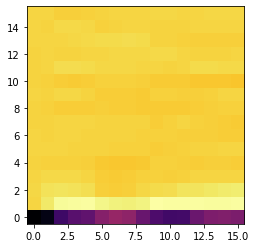

In [18]:
# Plot MFCC
fig = plt.figure()
plt.imshow(mfccs, cmap='inferno', origin='lower')

In [19]:
# TEST: Play problem sounds
print(target_list[int(y_orig_train[idx])])
#playsound(path)

noise


In [20]:
# Function: Create MFCCs, keeping only ones of desired length
def extract_features(in_files, in_y):
    prob_cnt = 0
    out_x = []
    out_y = []
        
    for index, filename in enumerate(in_files):
    
        # Create path from given filename and target item
        path = join(dataset_path, target_list[int(in_y[index])], 
                    filename)
        
        # Check to make sure we're reading a .wav file
        if not path.endswith('.wav'):
            continue

        # Create MFCCs
        mfccs = calc_mfcc(path)

        # Only keep MFCCs with given length
        if mfccs.shape[1] == len_mfcc:
            out_x.append(mfccs)
            out_y.append(in_y[index])
        else:
            print('Dropped:', index, mfccs.shape)
            os.remove(path)
            prob_cnt += 1
        #if "Copy" in path:
           # print("remove")
            #os.remove(path)
    return out_x, out_y, prob_cnt

In [21]:
# Create train, validation, and test sets
x_train, y_train, prob = extract_features(filenames_train, 
                                          y_orig_train)
print('Removed percentage:', prob / len(y_orig_train))
x_val, y_val, prob = extract_features(filenames_val, y_orig_val)
print('Removed percentage:', prob / len(y_orig_val))
x_test, y_test, prob = extract_features(filenames_test, y_orig_test)
print('Removed percentage:', prob / len(y_orig_test))

Removed percentage: 0.0
Removed percentage: 0.0
Removed percentage: 0.0


In [22]:
# Save features and truth vector (y) sets to disk
np.savez(feature_sets_file, 
         x_train=x_train, 
         y_train=y_train, 
         x_val=x_val, 
         y_val=y_val, 
         x_test=x_test, 
         y_test=y_test)

In [23]:
# TEST: Load features
feature_sets = np.load(feature_sets_file)
feature_sets.files

len(feature_sets['x_train'])

print(feature_sets['y_val'])

[1. 1. 1. 2. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 2. 0. 1. 1.
 1. 2. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 2. 1. 1. 0. 1. 1. 1. 2. 1. 1. 2.
 1. 1. 1. 1. 1. 0. 1. 0. 1. 2. 1. 1. 1. 1. 0. 2. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 0. 1. 1. 1. 1. 2. 1.
 0. 1. 1. 0. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 0. 2. 1. 1. 1. 0. 0. 1.
 0. 1. 1. 1. 2. 1.]


In [24]:
print(feature_sets.files)

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']


In [25]:
x_train = feature_sets['x_train']
y_train = feature_sets['y_train']
x_val = feature_sets['x_val']
y_val = feature_sets['y_val']
x_test = feature_sets['x_test']
y_test = feature_sets['y_test']

In [26]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(1012, 16, 16)
(126, 16, 16)
(126, 16, 16)


In [27]:
print(y_val)

[1. 1. 1. 2. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 2. 0. 1. 1.
 1. 2. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 2. 1. 1. 0. 1. 1. 1. 2. 1. 1. 2.
 1. 1. 1. 1. 1. 0. 1. 0. 1. 2. 1. 1. 1. 1. 0. 2. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 0. 1. 1. 1. 1. 2. 1.
 0. 1. 1. 0. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 0. 2. 1. 1. 1. 0. 0. 1.
 0. 1. 1. 1. 2. 1.]


In [28]:
x_train = x_train.reshape(x_train.shape[0], 
                          x_train.shape[1], 
                          x_train.shape[2], 
                          1)
x_val = x_val.reshape(x_val.shape[0], 
                      x_val.shape[1], 
                      x_val.shape[2], 
                      1)
x_test = x_test.reshape(x_test.shape[0], 
                        x_test.shape[1], 
                        x_test.shape[2], 
                        1)
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(1012, 16, 16, 1)
(126, 16, 16, 1)
(126, 16, 16, 1)


In [29]:
sample_shape = x_test.shape[1:]
print(sample_shape)

(16, 16, 1)


In [30]:
epochs = 50

num_classes = len(all_targets)

In [31]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, LSTM
from tensorflow.keras.utils import to_categorical
import wandb
from wandb.keras import WandbCallback

In [32]:
y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)
y_val_hot = to_categorical(y_val)

In [33]:
import tensorflow

In [34]:
tensorflow.config.run_functions_eagerly(True)


In [35]:
print(len(x_test))
print(len(y_test))
print(len(x_train))
print(len(y_train))
print(len(x_val))
print(len(y_val))

126
126
1012
1012
126
126


In [36]:
# build model
model = Sequential()
model.add(Conv2D(32,
(3, 3),
input_shape=(sample_shape),
activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32,
(3, 3),
activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.45))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.45))
model.add(Dense(num_classes, activation='softmax'))

In [37]:
model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=['accuracy'])

In [ ]:
wandb.init()
model.fit(x_train, y_train_hot, epochs=epochs, validation_data=(x_val, y_val_hot), callbacks=[WandbCallback(data_type="image", labels=all_targets)])

epoch,49
loss,0.02512
accuracy,0.99111
val_loss,0.05502
val_accuracy,0.99206
_runtime,63
_timestamp,1635424976
_step,49
best_val_loss,0.0146
best_epoch,39


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▄▅▆▆▇▇▇▇▇██████▇███████████████████████
val_loss,█▆▅▄▃▃▃▂▂▂▂▂▂▂▂▁▁▂▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂▂▁▁▂
val_accuracy,▁▂▄▅▆▇▇▇█▇█▇████████████████████████████
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 32)          9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
dropout (Dropout)            (None, 2, 2, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

In [40]:
model.evaluate(x=x_test, y=y_test_hot)

4/4 [==============================] - 0s 9ms/step - loss: 3.5831e-04 - accuracy: 1.0000


[0.00035830948036164045, 1.0]

In [41]:
from tensorflow.keras import  models

In [42]:
models.save_model(model, "model_1.h5")

In [43]:
print(y_test)
print(y_val)
print(y_train)

[1. 2. 1. 2. 1. 1. 1. 1. 1. 0. 2. 1. 1. 1. 1. 1. 1. 1. 1. 0. 2. 1. 2. 2.
 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 0. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 2.
 1. 0. 1. 1. 1. 1. 2. 0. 1. 0. 2. 2. 1. 1. 1. 2. 1. 1. 2. 1. 1. 1. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 2. 0. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 2. 2. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 0. 2. 1. 1. 1. 1.]
[1. 1. 1. 2. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 2. 0. 1. 1.
 1. 2. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 2. 1. 1. 0. 1. 1. 1. 2. 1. 1. 2.
 1. 1. 1. 1. 1. 0. 1. 0. 1. 2. 1. 1. 1. 1. 0. 2. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 0. 1. 1. 1. 1. 2. 1.
 0. 1. 1. 0. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 0. 2. 1. 1. 1. 0. 0. 1.
 0. 1. 1. 1. 2. 1.]
[1. 1. 1. ... 0. 1. 1.]
